In [1]:
# Optimal Control tutorial for three-level population transfer
# Copyright (C) 2021 Luigi Giannelli

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

import copy
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from tqdm.auto import tqdm

from ThreeLS import *

## hyperparameters

In [3]:
T = 1

Ωmax = 20
γ = 5

n_steps = 30

np.random.seed(11235813)

env_parameters = {
    "Ωmax": Ωmax,
    "n_steps": n_steps,
    "γ": γ,
    "T": T,
}

env_py = ThreeLS_v0_env(**env_parameters)

init_vals = np.random.rand(2 * n_steps) * Ωmax
init_amps = vals2amps(init_vals)
bounds = [(0, Ωmax) for a in range(2 * n_steps)]

## speed check

In [4]:
%timeit env_py.run_mesolvevolution(init_amps)
env_py.run_mesolvevolution(init_amps).states[-1]

28.5 ms ± 246 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.36644292+0.j          0.        +0.06222463j -0.22522254+0.j
   0.        +0.j        ]
 [ 0.        -0.06222463j  0.01056619+0.j          0.        +0.0382444j
   0.        +0.j        ]
 [-0.22522254+0.j          0.        -0.0382444j   0.1384259 +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.48456499+0.j        ]]

In [5]:
%timeit env_py.run_qstepevolution(init_amps)
env_py.run_qstepevolution(init_amps)[-1]

58 ms ± 470 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.366443  +0.j          0.        +0.06222454j -0.22522263+0.j
   0.        +0.j        ]
 [ 0.        -0.06222454j  0.01056616+0.j          0.        +0.03824435j
   0.        +0.j        ]
 [-0.22522263+0.j          0.        -0.03824435j  0.13842598+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.48456486+0.j        ]]

## initial efficiency with random pulses

In [4]:
# check initial efficiency
print(f"initial efficiency = {env_py.final_efficiency(init_amps)}")
print(f"initial inefficiency = {env_py.inefficiency(init_vals)}")
print(
    f"their sum is = {env_py.final_efficiency(init_amps) + env_py.inefficiency(init_vals)}"
)

# check initial efficiency with qstep
print("--- now with qstep")
print(f"initial efficiency = {env_py.final_qstepefficiency(init_amps)}")
print(f"initial inefficiency = {env_py.qstepinefficiency(init_vals)}")

initial efficiency = 0.13842590200230734
initial inefficiency = 0.8615740979976927
their sum is = 1.0
--- now with qstep
initial efficiency = 0.13842598413243223
initial inefficiency = 0.8615740158675678


final efficiency = 0.13842599093914032
final efficiency (mesolve) = 0.13842590200230734


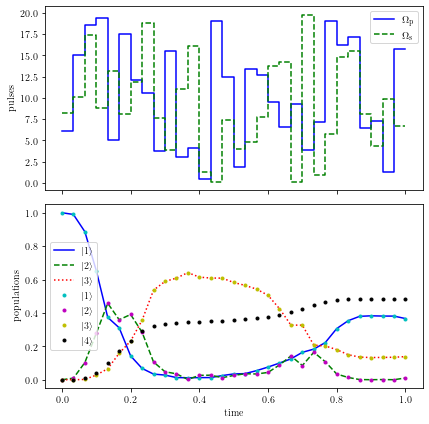

In [5]:
plot_evolution(init_amps, env_parameters, mesolve_check=True);

## optimization of the pulses - Powell

In [10]:
%%time

solver_opts_Powell = {
    "disp": True,
    "ftol": 1e-2,
    "xtol": 1e-3,
    "maxfev": int(1e4),
    "maxiter": int(1e3),
}

res = minimize(
    env_py.inefficiency,
    init_vals,
    args=(),
    method="Powell",
    bounds=bounds,
    options=solver_opts_Powell,
)

CPU times: user 6min 19s, sys: 757 ms, total: 6min 20s
Wall time: 6min 20s


In [11]:
# final efficiency
print(f"final efficiency = {env_py.final_efficiency(vals2amps(res.x))}")
print(f"final inefficiency = {env_py.inefficiency(res.x)}")
print(
    f"their sum is = {env_py.final_efficiency(vals2amps(res.x)) + env_py.inefficiency(res.x)}"
)

final efficiency = 0.886748374530654
final inefficiency = 0.11325162546934597
their sum is = 1.0


final efficiency = 0.8867483735084534
final efficiency (mesolve) = 0.886748374530654


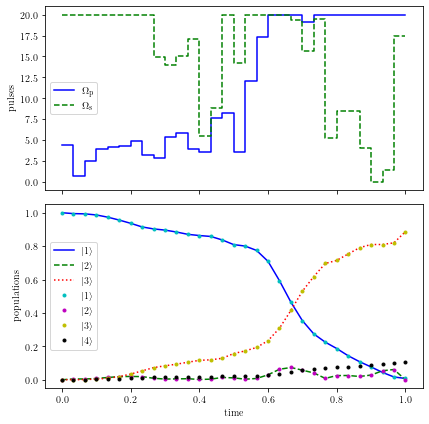

In [12]:
plot_evolution(vals2amps(res.x), env_parameters, mesolve_check=True);

## optimization of the pulses - Nelder-Mead

In [14]:
%%time

solver_opts_NM = {
    "disp": True,
    "fatol": 1e-2,
    "xatol": 1e-3,
    "maxfev": int(1e4),
    #"maxiter": int(1e3),
}

res = minimize(
    env_py.inefficiency,
    init_vals,
    args=(),
    method="Nelder-Mead",
    bounds=bounds,
    options=solver_opts_NM,
)

CPU times: user 6min 9s, sys: 264 ms, total: 6min 10s
Wall time: 6min 10s


In [15]:
# final efficiency
print(f"final efficiency = {env_py.final_efficiency(vals2amps(res.x))}")
print(f"final inefficiency = {env_py.inefficiency(res.x)}")
print(
    f"their sum is = {env_py.final_efficiency(vals2amps(res.x)) + env_py.inefficiency(res.x)}"
)

final efficiency = 0.8620313032924013
final inefficiency = 0.1379686967075987
their sum is = 1.0


final efficiency = 0.8620312809944153
final efficiency (mesolve) = 0.8620313032924013


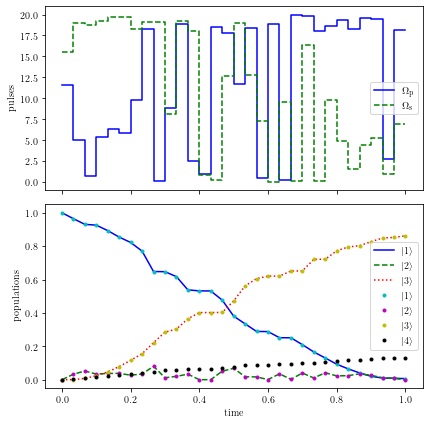

In [16]:
plot_evolution(vals2amps(res.x), env_parameters, mesolve_check=True);

## optimization of the pulses - L-BFGS-B

In [6]:
solver_opts_LBFGSB = {
    "disp": 0,
    # "maxcor":10,
    "ftol": 1e-10,
    "gtol": 1e-8,
    "eps": 1e-3,
    "maxfun": int(2e5),
    "maxiter": int(1e3),
    "maxls": 50
}

In [7]:
%%time
res = minimize(
    env_py.inefficiency,
    init_vals,
    args=(),
    method="L-BFGS-B",
    bounds=bounds,
    options=solver_opts_LBFGSB,
)

CPU times: user 5min 6s, sys: 284 ms, total: 5min 6s
Wall time: 5min 7s


In [8]:
# final efficiency
print(f"final efficiency = {env_py.final_efficiency(vals2amps(res.x))}")
print(f"final inefficiency = {env_py.inefficiency(res.x)}")
print(f"res.fun = {res.fun}")
print(f"result: {res.message}")

final efficiency = 0.9097932682395736
final inefficiency = 0.09020673176042637
res.fun = 0.09020673176042637
result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


final efficiency = 0.9097932577133179
final efficiency (mesolve) = 0.9097932682395736


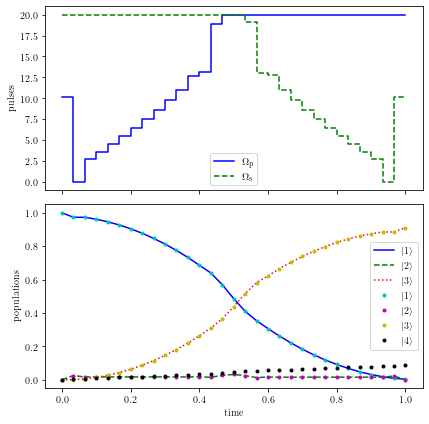

In [9]:
plot_evolution(vals2amps(res.x), env_parameters, mesolve_check=True);

# parallel execution

In [10]:
solver_opts_novb = solver_opts_LBFGSB.copy()
solver_opts_novb["disp"] = 0

parameters = {
    "env_parameters": env_parameters,
    "init_vals": init_vals,
    "bounds": bounds,
    "solver_opts": solver_opts_novb,
}

### as a function of $\Omega_\mathrm{max}$

In [11]:
env_parameters

{'Ωmax': 20, 'n_steps': 30, 'γ': 5, 'T': 1}

In [12]:
def Omm1rand(Ω_, env_parameters):
    return (Ω_ - 1) + np.random.rand(2 * env_parameters["n_steps"])
    # return (Ω_ - 1) + temptemp


def Om(Ω_, env_parameters):
    return Ω_ * np.ones(2 * env_parameters["n_steps"])


def Omgaussian(Ω_, env_parameters):
    T_ = env_parameters["T"]
    tlist = np.linspace(0, T, env_parameters["n_steps"], endpoint=False)

    return Ω_ * np.append(gaussian(tlist - 0.7 * T, T / 3),
                          gaussian(tlist - 0.3 * T, T / 3))


def Omrand(Ω_, env_parameters):
    return Ω_ * np.random.rand(2 * pars_["env_parameters"]["n_steps"])
    # return Ω_ * temptemp

In [13]:
Ωmaxs = np.linspace(1., 100., 32)

np.random.seed(1123581321)

init_funcs = [Om, Omm1rand, Omgaussian, Omrand]

input_pars = []
for Ω_ in Ωmaxs:
    pars_ = copy.deepcopy(parameters)
    pars_["env_parameters"]["Ωmax"] = Ω_
    pars_["bounds"] = [
        (0, Ω_) for a in range(2 * pars_["env_parameters"]["n_steps"])
    ]
    
    # temptemp = np.random.rand(2 * env_parameters["n_steps"])
    
    for func in init_funcs:
        pars_ = copy.deepcopy(pars_)
        pars_["init_vals"] = func(Ω_, pars_["env_parameters"])
        input_pars.append(pars_)

In [183]:
data = []
with Pool(processes=32) as pool:
    for x in tqdm(pool.imap(optimize_vs_pars, input_pars),
                  total=len(input_pars)):
        data += [x]

  0%|          | 0/128 [00:00<?, ?it/s]

/home/luigi/.pyenv/versions/3.9.7/envs/threeLS/lib/python3.9/site-packages/scipy/integrate/_ode.py:1013: UserWarning: zvode: Repeated error test failures. (Check all input.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


In [188]:
ip = np.reshape(input_pars, (-1, len(init_funcs)))
d = np.reshape(data, (-1, len(init_funcs)))
# save_object([ip, d], "./data/gamma5_vs_Om.pkl")

In [14]:
ip, d = load_object("./data/gamma5_vs_Om.pkl")

In [15]:
nx, ny = ip.shape
assert nx, ny == d.shape

Ωmax_list = np.zeros((nx, ny))
ineff_list = np.zeros((nx, ny))
converging = np.zeros((nx, ny), dtype=bool)
for i in range(nx):
    for j in range(ny):
        Ωmax_list[i, j] = ip[i, j]["env_parameters"]["Ωmax"]
        try:
            ineff_list[i, j] = d[i, j].fun
            converging[i, j] = d[i, j].success
        except:
            ineff_list[i, j] = 1.
            converging[i, j] = False

ineff_list[ineff_list < 1e-6] = 1e-6

In [16]:
# check if the minimization algorithm converged for every Ωmax
converged = np.all(converging)
print(f"has the minimization algorithm converged for every Ωmax? {converged}")
if not converged:
    print(
        f"indexes at which I did not converge: {np.argwhere(converging==False)}"
    )

has the minimization algorithm converged for every Ωmax? False
indexes at which I did not converge: [[ 2  2]
 [ 3  0]
 [ 3  3]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 8  0]
 [12  3]
 [17  3]
 [26  2]
 [30  3]
 [31  3]]


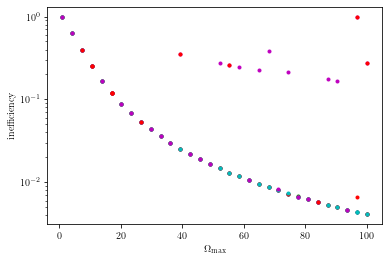

In [17]:
fig, ax = plt.subplots(1, 1)

ax.set_xlabel(r"$\Omega_\mathrm{max}$")
ax.set_ylabel("inefficiency")

# ax.set_xscale("log")
ax.set_yscale("log")

ax.plot(Ωmax_list[:, 0], ineff_list.min(axis=1), ".")
ax.plot(Ωmax_list[:, 0], ineff_list, ".")
ax.plot(Ωmax_list[~converging], ineff_list[~converging].T, ".", color="red")

final efficiency = 0.9958714246749878
final efficiency (mesolve) = 0.9958714155402847
result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


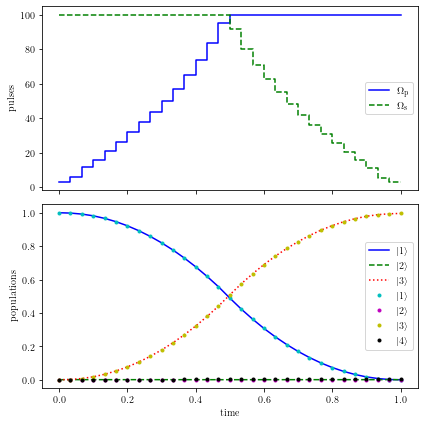

In [18]:
# plot evolution `i`
i = -1
plot_evolution(vals2amps(d[i, 0].x),
               ip[i, 0]["env_parameters"],
               mesolve_check=True)
print(f"result: {d[i,0].message}")

# from saved data

In [19]:
filenames = ["./data/gamma1_vs_Om.pkl", "./data/gamma5_vs_Om.pkl"]

labels = [
    r"$T\gamma = 1$",
    r"$T\gamma = 5$",
]

markers = [
    ".",
    "+",
]

In [20]:
input_pars = []
data = []
Ωmax_lists = []
ineff_lists = []

for filename in filenames:
    ip, d = load_object(filename)

    nx, ny = ip.shape
    assert nx, ny == d.shape

    Ωmax_list = np.zeros((nx, ny))
    ineff_list = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            Ωmax_list[i, j] = ip[i, j]["env_parameters"]["Ωmax"]
            try:
                ineff_list[i, j] = d[i, j].fun
            except:
                ineff_list[i, j] = 1.

    input_pars.append(ip)
    data.append(d)
    Ωmax_lists.append(Ωmax_list)
    ineff_lists.append(ineff_list)

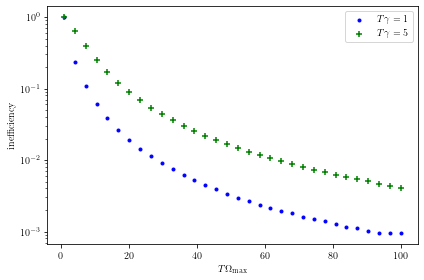

In [21]:
fig, ax = plt.subplots(1, 1)

ax.set_xlabel(r"$T\Omega_\mathrm{max}$")
ax.set_ylabel("inefficiency")

#ax.set_ylim(5e-4, 1)

# ax.set_xscale("log")
ax.set_yscale("log")
for i in range(len(filenames)):
    # ax.plot(Ωmax_list[:, 0], ineff_list, ".")
    ax.scatter(Ωmax_lists[i][:, 0],
               ineff_lists[i].min(axis=1),
               marker=markers[i],
               label=labels[i])

ax.legend()
fig.tight_layout()